In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

In [2]:
# KDD dataset columns names as dataset comes without column names
columns_name = ['duration', 'protocol_type','service',
           'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
           'urgent', 'hot', 'num_failed_logins', 'logged_in','num_compromised',
           'root_shell','su_attempted','num_root','num_file_creations',
           'num_shells','num_access_files','num_outbound_cmds','is_host_login',
           'is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
           'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
           'srv_diff_host_rate','dst_host_count','dst_host_srv_count',
           'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
           'dst_host_rerror_rate','dst_host_srv_rerror_rate','label','noidea']

In [3]:
# importing training and test dataset
train_df = pd.read_csv('KDDTrain+.txt',header=None,names = columns_name)
test_df = pd.read_csv('KDDTest+.txt',header=None,names = columns_name)

In [4]:
# make copy for binary classification
train_bin = train_df.copy()
test_bin = test_df.copy()

In [5]:
#drop columns , it is not useful in analysis
train_df.drop(columns=['noidea','num_outbound_cmds','protocol_type','service','flag'],inplace=True)
test_df.drop(columns=['noidea','num_outbound_cmds','protocol_type','service','flag'],inplace=True)


In [6]:
# changing intrusion attacks labels to their respective category
def change_label(df):
    df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
    df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
    df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [7]:
change_label(train_df)
change_label(test_df)

In [8]:
train_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,491,0,0,0,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,146,0,0,0,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,0,0,0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos
3,0,232,8153,0,0,0,0,0,1,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,199,420,0,0,0,0,0,1,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [9]:
X_train = train_df.drop(['label'],axis=1)
X_test = test_df.drop(['label'],axis=1)

In [10]:
# Binary Labelling
binary_train = pd.DataFrame(train_df.label.map(lambda x:'normal' if x=='normal' else 'abnormal'))
binary_test = pd.DataFrame(test_df.label.map(lambda x:'normal' if x=='normal' else 'abnormal'))
binary_test.head()

,label
0,abnormal
1,abnormal
2,normal
3,abnormal
4,abnormal


In [11]:
# make a copy of label as above models consider normal as 0 and abnormal as 1 and i have previously for other models did opposite 
ntest_label = binary_test.copy()
ntrain_label = binary_train.copy()
# Binary Labelling
ntest_label['label'].replace("normal",0,inplace=True)
ntest_label['label'].replace("abnormal",1,inplace=True)

ntrain_label['label'].replace("normal",0,inplace=True)
ntrain_label['label'].replace("abnormal",1,inplace=True)

In [12]:
# make a copy of label as above models consider normal as 0 and abnormal as 1 and i have previously for other models did opposite 
test_label = binary_test.copy()
train_label = binary_train.copy()
# Binary Labelling
test_label['label'].replace("normal",1,inplace=True)
test_label['label'].replace("abnormal",-1,inplace=True)

train_label['label'].replace("normal",1,inplace=True)
train_label['label'].replace("abnormal",-1,inplace=True)

In [13]:
test_label.head()

,label
0,-1
1,-1
2,1
3,-1
4,-1


In [14]:
binary_train.value_counts()/binary_train.shape[0]

label   
normal      0.534583
abnormal    0.465417
dtype: float64

In [15]:
#normalize numeric data
'''
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)
'''

'\nscaler = StandardScaler()\nscaler.fit(X_train)\nX_train = scaler.transform(X_train)\n\nX_test = scaler.transform(X_test)\n'

In [16]:
X_test.shape

(22544, 37)

## Isolation Forest

In [17]:
clfIF = IsolationForest(max_samples=0.65, random_state=11, contamination=0.46, n_estimators=100, n_jobs=-1)

In [18]:
clfIF.fit(X_train)

IsolationForest(contamination=0.46, max_samples=0.65, n_jobs=-1,
                random_state=11)

In [19]:
y_pred_train = clfIF.predict(X_train)
np.unique(y_pred_train)

array([-1,  1])

In [20]:
conf_matrix = confusion_matrix(train_label, y_pred_train)
conf_matrix

array([[31403, 27227],
       [26544, 40799]])

In [21]:
y_pred_test = clfIF.predict(X_test)
conf_matrix_if_test = confusion_matrix(test_label, y_pred_test)
conf_matrix_if_test

array([[10372,  2461],
       [ 2530,  7181]])

In [22]:
print(classification_report(test_label, y_pred_test))

              precision    recall  f1-score   support

          -1       0.80      0.81      0.81     12833
           1       0.74      0.74      0.74      9711

    accuracy                           0.78     22544
   macro avg       0.77      0.77      0.77     22544
weighted avg       0.78      0.78      0.78     22544



## OCSVM

In [23]:
from sklearn import svm
clfOC = svm.OneClassSVM(nu=0.46, kernel="rbf")

In [24]:
clfOC.fit(X_train)
y_pred_trainOC = clfOC.predict(X_train)
np.unique(y_pred_trainOC)

array([-1,  1])

In [25]:
y_pred_testOC = clfOC.predict(X_test)
conf_matrix_OC_test = confusion_matrix(test_label, y_pred_testOC)
conf_matrix_OC_test

array([[8267, 4566],
       [1135, 8576]])

In [26]:
print(classification_report(test_label, y_pred_testOC))

              precision    recall  f1-score   support

          -1       0.88      0.64      0.74     12833
           1       0.65      0.88      0.75      9711

    accuracy                           0.75     22544
   macro avg       0.77      0.76      0.75     22544
weighted avg       0.78      0.75      0.75     22544



## Local Outlier Factor

In [27]:
clfLOF = LocalOutlierFactor(n_neighbors=100, metric='l1', algorithm='auto', contamination=0.46, n_jobs=1)
clfLOF.fit(X_train)

LocalOutlierFactor(contamination=0.46, metric='l1', n_jobs=1, n_neighbors=100)

In [28]:
y_pred_train_lof = clfLOF.fit_predict(X_train)
np.unique(y_pred_train_lof)

array([-1,  1])

In [29]:
conf_matrix_lof = confusion_matrix(train_label, y_pred_train_lof)
conf_matrix_lof

array([[25071, 33559],
       [32877, 34466]])

In [30]:
y_pred_test_lof = clfLOF.fit_predict(X_test)
conf_matrix_lof_test = confusion_matrix(test_label, y_pred_test_lof)
conf_matrix_lof_test

array([[6357, 6476],
       [4013, 5698]])

In [31]:
print(classification_report(test_label, y_pred_test_lof))

              precision    recall  f1-score   support

          -1       0.61      0.50      0.55     12833
           1       0.47      0.59      0.52      9711

    accuracy                           0.53     22544
   macro avg       0.54      0.54      0.53     22544
weighted avg       0.55      0.53      0.54     22544



In [32]:
accuracy_score(test_label,y_pred_test_lof)

0.5347320794889993

## Decison Tree

In [33]:
from sklearn import tree
clfdtree = tree.DecisionTreeClassifier()
clfdtree.fit(X_train, ntrain_label)

y_pred_tree = clfdtree.predict(X_test)
conf_matrix_tree_test = confusion_matrix(ntest_label, y_pred_tree)
print(conf_matrix_tree_test)
print(classification_report(ntest_label, y_pred_tree))

[[9446  265]
 [4611 8222]]
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.64      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



## Linear SVM

In [34]:
from sklearn.svm import LinearSVC
clfsvm = LinearSVC()
clfsvm.fit(X_train, ntrain_label)

y_pred_svm = clfsvm.predict(X_test)
conf_matrix_svm_test = confusion_matrix(ntest_label, y_pred_svm)
print(conf_matrix_svm_test)
print(classification_report(ntest_label, y_pred_svm))

/Users/amardeepsingh/PycharmProjects/CourseNL/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[9378  333]
 [5904 6929]]
              precision    recall  f1-score   support

           0       0.61      0.97      0.75      9711
           1       0.95      0.54      0.69     12833

    accuracy                           0.72     22544
   macro avg       0.78      0.75      0.72     22544
weighted avg       0.81      0.72      0.72     22544



/Users/amardeepsingh/PycharmProjects/CourseNL/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [35]:
accuracy_score(ntest_label, y_pred_svm)

0.7233410220014195

## Naive Bayes

In [36]:
from sklearn.svm import LinearSVC
clfsvm = LinearSVC()
clfsvm.fit(X_train, ntrain_label)

y_pred_svm = clfsvm.predict(X_test)
conf_matrix_svm_test = confusion_matrix(ntest_label, y_pred_svm)
print(conf_matrix_svm_test)
print(classification_report(ntest_label, y_pred_svm))

/Users/amardeepsingh/PycharmProjects/CourseNL/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[8758  953]
 [5318 7515]]
              precision    recall  f1-score   support

           0       0.62      0.90      0.74      9711
           1       0.89      0.59      0.71     12833

    accuracy                           0.72     22544
   macro avg       0.75      0.74      0.72     22544
weighted avg       0.77      0.72      0.72     22544



/Users/amardeepsingh/PycharmProjects/CourseNL/venv/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Ransom Forest

## Pyod SOGAAL

In [37]:
from pyod.models.so_gaal import SO_GAAL
clf_GAAL = SO_GAAL(contamination=0.465)
clf_GAAL.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_predGAAL = clf_GAAL.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scoresGAAL = clf_GAAL.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_predGAAL = clf_GAAL.predict(X_test)  # outlier labels (0 or 1)
y_test_scoresGAAL = clf_GAAL.decision_function(X_test)  # outlier scores


print("\nOn ROC on Test Data:")
print(round(roc_auc_score(ntest_label, y_test_scoresGAAL), ndigits=4))
print("\nOn classification report on Test Data:")
print(classification_report(ntest_label, y_test_predGAAL))

/Users/amardeepsingh/PycharmProjects/CourseNL/venv/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:

Testing for epoch 1 index 17:

Testing for epoch 1 index 18:

Testing for epoch 1 index 19:

Testing for epoch 1 index 20:

Testing for epoch 1 index 21:

Testing for epoch 1 index 22:

Testing for epoch 1 index 23:

Testing for epoch 1 index 24:

Testing for epoch 1 index 25:

Testing for epoch 1 index 26:

Testing for epoch 1 index 27:

Testing for epoch 1 index 28:

Testing for epoch 1 index 29:

Testing for epoch 1 index 30:

Testing for epoch 1 index 31:

Testing for epoch 1 index 32:

Te

/Users/amardeepsingh/PycharmProjects/CourseNL/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
from pyod.models.mo_gaal import MO_GAAL
clf_GAAL = MO_GAAL(k=3, stop_epochs=2,contamination=0.465)
clf_GAAL.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_predGAAL = clf_GAAL.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scoresGAAL = clf_GAAL.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_predGAAL = clf_GAAL.predict(X_test)  # outlier labels (0 or 1)
y_test_scoresGAAL = clf_GAAL.decision_function(X_test)  # outlier scores


print("\nOn ROC on Test Data:")
print(round(roc_auc_score(ntest_label, y_test_scoresGAAL), ndigits=4))
print("\nOn classification report on Test Data:")
print(classification_report(ntest_label, y_test_predGAAL))

Epoch 1 of 6

Testing for epoch 1 index 1:


/Users/amardeepsingh/PycharmProjects/CourseNL/venv/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")



Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:

Testing for epoch 1 index 17:

Testing for epoch 1 index 18:

Testing for epoch 1 index 19:

Testing for epoch 1 index 20:

Testing for epoch 1 index 21:

Testing for epoch 1 index 22:

Testing for epoch 1 index 23:

Testing for epoch 1 index 24:

Testing for epoch 1 index 25:

Testing for epoch 1 index 26:

Testing for epoch 1 index 27:

Testing for epoch 1 index 28:

Testing for epoch 1 index 29:

Testing for epoch 1 index 30:

Testing for epoch 1 index 31:

Testing for epoch 1 index 32:

Testing for epoch 1 index 33:

Testing for epo

/Users/amardeepsingh/PycharmProjects/CourseNL/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBoost

In [39]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, ntrain_label)

y_pred_xg = xgb.predict(X_test)
conf_matrix_xg_test = confusion_matrix(ntest_label, y_pred_xg)
print(conf_matrix_xg_test)
print(classification_report(ntest_label, y_pred_xg))

/Users/amardeepsingh/PycharmProjects/CourseNL/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/amardeepsingh/PycharmProjects/CourseNL/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[21:24:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[9460  251]
 [4673 8160]]
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.64      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



In [40]:
accuracy_score(ntest_label, y_pred_xg)

0.781582682753726

In [41]:
#!brew install libomp

# KNN

In [42]:
from pyod.models.knn import KNN 

In [43]:
# train kNN detector
clf_name = 'KNN'
clfKNN = KNN(n_neighbors=15, contamination=0.46, method='largest')
clfKNN.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clfKNN.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clfKNN.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clfKNN.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clfKNN.decision_function(X_test)  # outlier scores

In [44]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, ntrain_label, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, ntest_label, y_test_scores)


On Training Data:
KNN ROC:0.0709, precision @ rank n:0.079

On Test Data:
KNN ROC:0.289, precision @ rank n:0.3873


In [45]:
print(classification_report(ntest_label, y_test_pred))

              precision    recall  f1-score   support

           0       0.16      0.14      0.15      9711
           1       0.40      0.42      0.41     12833

    accuracy                           0.30     22544
   macro avg       0.28      0.28      0.28     22544
weighted avg       0.29      0.30      0.30     22544



In [46]:
kdd_features=['srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [47]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

## pyod IForest

In [48]:
clf_IFo = IForest(contamination=0.465,random_state=42)
clf_IFo.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf_IFo.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf_IFo.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf_IFo.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf_IFo.decision_function(X_test)  # outlier scores


print("\nOn ROC on Test Data:")
print(round(roc_auc_score(ntest_label, y_test_scores), ndigits=4))
print("\nOn classification report on Test Data:")
print(classification_report(ntest_label, y_test_pred))


On ROC on Test Data:
0.8898

On classification report on Test Data:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      9711
           1       0.85      0.80      0.82     12833

    accuracy                           0.81     22544
   macro avg       0.80      0.81      0.80     22544
weighted avg       0.81      0.81      0.81     22544



In [49]:
accuracy_score(ntest_label, y_test_pred)

0.806334279630944

## Pyod ABOD

In [50]:
'''
clf_ABOD = ABOD(contamination=0.465,n_neighbors=25, method='fast')
clf_ABOD.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_predABOD = clf_ABOD.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scoresABOD = clf_ABOD.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_predABOD = clf_ABOD.predict(X_test)  # outlier labels (0 or 1)
y_test_scoresABOD = clf_ABOD.decision_function(X_test)  # outlier scores



#print("\nOn ROC on Test Data:")
#print(round(roc_auc_score(ntest_label, y_test_scoresABOD), ndigits=4))
print("\nOn classification report on Test Data:")
print(classification_report(ntest_label, y_test_predABOD))
'''

'\nclf_ABOD = ABOD(contamination=0.465,n_neighbors=25, method=\'fast\')\nclf_ABOD.fit(X_train)\n\n# get the prediction labels and outlier scores of the training data\ny_train_predABOD = clf_ABOD.labels_  # binary labels (0: inliers, 1: outliers)\ny_train_scoresABOD = clf_ABOD.decision_scores_  # raw outlier scores\n\n# get the prediction on the test data\ny_test_predABOD = clf_ABOD.predict(X_test)  # outlier labels (0 or 1)\ny_test_scoresABOD = clf_ABOD.decision_function(X_test)  # outlier scores\n\n\n\n#print("\nOn ROC on Test Data:")\n#print(round(roc_auc_score(ntest_label, y_test_scoresABOD), ndigits=4))\nprint("\nOn classification report on Test Data:")\nprint(classification_report(ntest_label, y_test_predABOD))\n'

## PYOD CBLOF

In [51]:
clf_CBLOF = CBLOF(contamination=0.465,check_estimator=False,random_state=42)
clf_CBLOF.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_predCBLOF = clf_CBLOF.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scoresCBLOF = clf_CBLOF.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_predCBLOF= clf_CBLOF.predict(X_test)  # outlier labels (0 or 1)
y_test_scoresCBLOF = clf_CBLOF.decision_function(X_test)  # outlier scores


print("\nOn ROC on Test Data:")
print(round(roc_auc_score(ntest_label, y_test_scoresCBLOF), ndigits=4))
print("\nOn classification report on Test Data:")
print(classification_report(ntest_label, y_test_predCBLOF))

/Users/amardeepsingh/PycharmProjects/CourseNL/venv/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)



On ROC on Test Data:
0.7763

On classification report on Test Data:
              precision    recall  f1-score   support

           0       0.63      0.86      0.72      9711
           1       0.85      0.61      0.71     12833

    accuracy                           0.72     22544
   macro avg       0.74      0.74      0.72     22544
weighted avg       0.76      0.72      0.72     22544



In [52]:
accuracy_score(ntest_label, y_test_predCBLOF)

0.7189052519517388

## PYOD HBOS

In [53]:
clf_HBOS = HBOS(contamination=0.465)#,check_estimator=False,random_state=42)
clf_HBOS.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_predHBOS = clf_HBOS.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scoresHBOS = clf_HBOS.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_predHBOS= clf_HBOS.predict(X_test)  # outlier labels (0 or 1)
y_test_scoresHBOS = clf_HBOS.decision_function(X_test)  # outlier scores


print("\nOn ROC on Test Data:")
print(round(roc_auc_score(ntest_label, y_test_scoresHBOS), ndigits=4))
print("\nOn classification report on Test Data:")
print(classification_report(ntest_label, y_test_predHBOS))


On ROC on Test Data:
0.8364

On classification report on Test Data:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      9711
           1       0.86      0.76      0.80     12833

    accuracy                           0.79     22544
   macro avg       0.79      0.79      0.79     22544
weighted avg       0.80      0.79      0.79     22544



In [54]:
accuracy_score(ntest_label, y_test_predHBOS)

0.7886799148332151

## PYOD OCSVM

In [55]:
'''
clf_OCSVM = OCSVM()#,check_estimator=False,random_state=42)
clf_OCSVM.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_predOCSVM = clf_OCSVM.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scoresOCSVM = clf_OCSVM.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_predOCSVM= clf_OCSVM.predict(X_test)  # outlier labels (0 or 1)
y_test_scoresOCSVM = clf_OCSVM.decision_function(X_test)  # outlier scores


print("\nOn ROC on Test Data:")
print(round(roc_auc_score(ntest_label, y_test_scoresOCSVM), ndigits=4))
print("\nOn classification report on Test Data:")
print(classification_report(ntest_label, y_test_predOCSVM))
'''

'\nclf_OCSVM = OCSVM()#,check_estimator=False,random_state=42)\nclf_OCSVM.fit(X_train)\n\n# get the prediction labels and outlier scores of the training data\ny_train_predOCSVM = clf_OCSVM.labels_  # binary labels (0: inliers, 1: outliers)\ny_train_scoresOCSVM = clf_OCSVM.decision_scores_  # raw outlier scores\n\n# get the prediction on the test data\ny_test_predOCSVM= clf_OCSVM.predict(X_test)  # outlier labels (0 or 1)\ny_test_scoresOCSVM = clf_OCSVM.decision_function(X_test)  # outlier scores\n\n\nprint("\nOn ROC on Test Data:")\nprint(round(roc_auc_score(ntest_label, y_test_scoresOCSVM), ndigits=4))\nprint("\nOn classification report on Test Data:")\nprint(classification_report(ntest_label, y_test_predOCSVM))\n'

## PYOD PCA

In [56]:
clf_PCA = PCA(contamination=0.465,random_state=42)
clf_PCA.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_predPCA = clf_PCA.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scoresPCA = clf_PCA.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_predPCA = clf_PCA.predict(X_test)  # outlier labels (0 or 1)
y_test_scoresPCA = clf_PCA.decision_function(X_test)  # outlier scores


print("\nOn ROC on Test Data:")
print(round(roc_auc_score(ntest_label, y_test_scoresPCA), ndigits=4))
print("\nOn classification report on Test Data:")
print(classification_report(ntest_label, y_test_predPCA))


On ROC on Test Data:
0.8074

On classification report on Test Data:
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      9711
           1       0.86      0.73      0.79     12833

    accuracy                           0.78     22544
   macro avg       0.78      0.78      0.77     22544
weighted avg       0.79      0.78      0.78     22544



In [57]:
accuracy_score(ntest_label, y_test_predPCA)

0.7755500354861604

## PYOD COPOD

In [58]:
from pyod.models.copod import COPOD
clf_COPOD = COPOD(contamination=0.465,n_jobs=1)
clf_COPOD.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_predCOPOD = clf_COPOD.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scoresCOPOD = clf_COPOD.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_predCOPOD = clf_COPOD.predict(X_test)  # outlier labels (0 or 1)
y_test_scoresCOPOD = clf_COPOD.decision_function(X_test)  # outlier scores


print("\nOn ROC on Test Data:")
print(round(roc_auc_score(ntest_label, y_test_scoresCOPOD), ndigits=4))
print("\nOn classification report on Test Data:")
print(classification_report(ntest_label, y_test_predCOPOD))


On ROC on Test Data:
0.8435

On classification report on Test Data:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      9711
           1       0.82      0.79      0.81     12833

    accuracy                           0.78     22544
   macro avg       0.78      0.78      0.78     22544
weighted avg       0.79      0.78      0.78     22544



In [59]:
accuracy_score(ntest_label, y_test_predCOPOD)

0.7840223562810504

## PYOD AUTOENCODER

In [60]:
from tensorflow.keras import backend as k
from pyod.utils.data import generate_data
from pyod.models.auto_encoder import AutoEncoder
#from keras.utils import plot_model

from keras.utils.vis_utils import model_to_dot 
from IPython.display import SVG

In [61]:
clfAE = AutoEncoder(epochs=10, contamination=0.465)
clfAE.fit(X_train)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 37)                1406      
_________________________________________________________________
dropout (Dropout)            (None, 37)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 37)                1406      
_________________________________________________________________
dropout_1 (Dropout)          (None, 37)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2432      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)               

AutoEncoder(batch_size=32, contamination=0.465, dropout_rate=0.2, epochs=10,
      hidden_activation='relu', hidden_neurons=[64, 32, 32, 64],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x178778e18>, optimizer='adam',
      output_activation='sigmoid', preprocessing=True, random_state=None,
      validation_size=0.1, verbose=1)

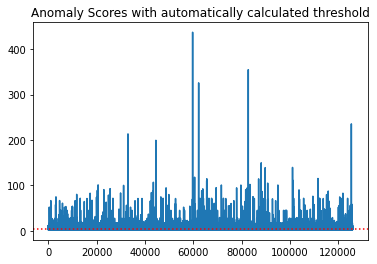

In [62]:
y_train_predAE = clfAE.labels_  
y_train_scoresAE = clfAE.decision_scores_ 
plt.plot(y_train_scoresAE);
plt.axhline(y=clfAE.threshold_, c='r', ls='dotted', label='threshoold');
plt.title('Anomaly Scores with automatically calculated threshold');

In [63]:
# get the prediction on the test data
y_test_predAE= clfAE.predict(X_test)  # outlier labels (0 or 1)
y_test_scoresAE = clfAE.decision_function(X_test)  # outlier scores


print("\nOn ROC on Test Data:")
print(round(roc_auc_score(ntest_label, y_test_scoresAE), ndigits=4))
print("\nOn classification report on Test Data:")
print(classification_report(ntest_label, y_test_predAE))


On ROC on Test Data:
0.8074

On classification report on Test Data:
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      9711
           1       0.86      0.73      0.79     12833

    accuracy                           0.78     22544
   macro avg       0.78      0.78      0.77     22544
weighted avg       0.79      0.78      0.78     22544



In [64]:
accuracy_score(ntest_label,y_test_predAE)


0.7753282469836764

In [65]:
ntest_label.label[ntest_label.label==0].index

Int64Index([    2,     5,     6,     8,    11,    14,    15,    16,    17,
               18,
            ...
            22523, 22526, 22527, 22529, 22532, 22533, 22535, 22539, 22540,
            22542],
           dtype='int64', length=9711)

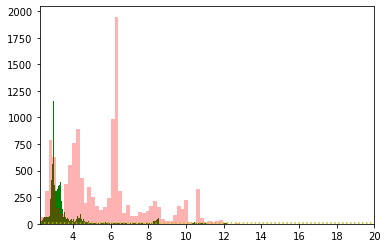

In [66]:
plt.hist(y_test_scoresAE[ntest_label.label[ntest_label.label==0].index], bins='auto', facecolor='g')
plt.hist(y_test_scoresAE[ntest_label.label[ntest_label.label==1].index], bins='auto', facecolor='r', alpha =0.3)
plt.axhline(y=clfAE.threshold_, c='y', ls='dotted', label='threshoold');
plt.xlim(min(y_test_scoresAE), 20)
plt.show()

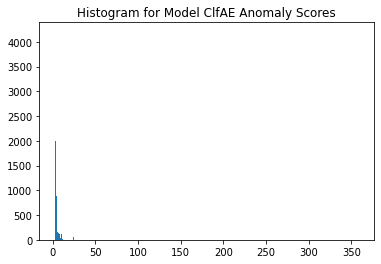

In [67]:
plt.hist(y_test_scoresAE, bins='auto')  
plt.title("Histogram for Model ClfAE Anomaly Scores")
plt.show()

## PYOD LOF

In [68]:
from pyod.models.lof import LOF
clf_LOF = LOF(contamination=0.465,n_jobs=1)
clf_LOF.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_predLOF = clf_LOF.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scoresLOF = clf_LOF.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_predLOF = clf_LOF.predict(X_test)  # outlier labels (0 or 1)
y_test_scoresLOF = clf_LOF.decision_function(X_test)  # outlier scores


print("\nOn ROC on Test Data:")
print(round(roc_auc_score(ntest_label, y_test_scoresLOF), ndigits=4))
print("\nOn classification report on Test Data:")
print(classification_report(ntest_label, y_test_predLOF))


On ROC on Test Data:
0.6195

On classification report on Test Data:
              precision    recall  f1-score   support

           0       0.51      0.40      0.45      9711
           1       0.61      0.71      0.66     12833

    accuracy                           0.58     22544
   macro avg       0.56      0.55      0.55     22544
weighted avg       0.57      0.58      0.57     22544

